**Project NL3.14**

In [ ]:
# Mount to Google Drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Imports We need in the project
import os
import re
import torch
import glob
import string
import math
import random

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import zipfile
import seaborn as sbr
import matplotlib.pyplot as plt 
import pandas as pd
import functools
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

SEED = 147
torch.manual_seed(SEED)
torch.__version__

'1.7.0+cu101'

In [ ]:
!pip install --upgrade pip
!pip install transformers
!pip install bpemb

from bpemb import BPEmb
from transformers import BertTokenizer, BertModel, AutoTokenizer, AdamW, BertForMaskedLM, Adafactor

     |████████████████████████████████| 1.5MB 5.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 1.8 MB 5.8 MB/s 
     |████████████████████████████████| 2.9 MB 28.0 MB/s 
     |████████████████████████████████| 883 kB 58.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893258 sha256=dc7ddbb754a253aae05cbee98452f11ad27cb670f2307604daa5b64fc8639478
  Stored in directory: /root/.cache/pip/wheels/49/25/98/cdea9c79b2d9a22ccc59540b1784b67f06b633378e97f58da2
Successfully built sacremoses
     |████████████████████████████████| 1.2 MB 5.6 MB/s 


**Start Working on Data**

In [ ]:
# helper class to parse and tokenize georgian data
class GeoData:
    def __init__(self, text):
     self.txt = text
     self.sentences = []

     self.alphabet = self.get_geoalphabet()
     self.alphabet.extend(self.get_arabian_nums())
     self.alphabet.extend(self.get_romanian_nums())
     self.alphabet.extend(self.get_optional_symbols()) 
     # create pattern with our alphabet for regex
     self.pattern = re.compile(r"^[" + ''.join(self.alphabet) + r"]+$")
     # train data
     self.__process__()

    def get_alphabet(self):
      return self.alphabet

    def get_geoalphabet(self):
      alphabet = ['ა', 'ბ', 'გ', 'დ', 'ე', 'ვ', 'ზ', 'თ', 'ი', 'კ', 'ლ', 'მ', 'ნ', 'ო', 'პ', 'ჟ', 'რ', 'ს', 'ტ', 'უ', 'ფ', 'ქ', 'ღ', 'ყ', 'შ', 'ჩ', 'ც', 'ძ', 'წ', 'ჭ', 'ხ', 'ჯ', 'ჰ']
      assert len(set(alphabet)) == 33
      return alphabet 

    def get_arabian_nums(self):
      return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
    def get_romanian_nums(self):
      return ['X', 'I', 'V', 'L', 'C', 'D', 'M']

    def get_optional_symbols(self):
      return ['-']

    def get_badsymbols(self):
     return ['\n', '\t', '_', '+', '=', '*', '&', '%', '$', '#', '@', '^', '/', '~', '„', ',,', '”', '“']

    def get_punctuation(self):
      return ['.', ';', '!', '?', ',', ':']

    def get_endofsentence(self):
      return ['»', '«', '[', ']', '{', '}', '(', ')', '...']

    def get_sentences(self):
      return self.sentences

    def configure_word(self, w):
      w = w.strip() # remove extra white spaces
      if w.count('-') > 1: return False, '.' # check count of '-' to avoid bad words
      if w == '-' or w[0] == '-': return True, '' + w[1:] # check if word is start of dialog
      if len(w) > 15: return False, '.' # check word length to avoid coruptted words
      if (w not in self.get_alphabet() and self.pattern.match(w)) or w in [',', ':']: # because of regex syntax, check custom if words is good for our alphabet
        if w[len(w)-1] == '‐' or w[len(w)-1] == '-': # note - these two chars are different!
          return True, w[:len(w)-1] # remove no need char
        return True, w + ' ' # add white space for next word
      return False, '.' # fix end of sentence
                      
    def __process__(self):
      # clean from bad symbols
      for dl in self.get_badsymbols():
        self.txt = self.txt.replace(dl, ' ')

      # fix end of sentences and replace them with '.'
      for sw in self.get_endofsentence():
        self.txt = self.txt.replace(sw, '.')

      # split punctuation from words
      for pn in self.get_punctuation():
        self.txt = self.txt.replace(pn, ' ' + pn + ' ')
      
      # remove extra white spaces
      self.txt = re.sub(r'\s+', ' ', self.txt).strip()

      # build sentences
      sentence, length = '', 0
      for w in self.txt.split(' '):
          is_word, word = self.configure_word(w)
          
          if is_word or word in ['.', ';', '!', '?']:
            sentence, length = sentence + word, length + (1 if len(word) > 1 else 0)

          if not is_word or word in ['.', ';', '!', '?']:
            if length >= 2: self.sentences.append(sentence.strip())
            sentence, length = '', 0
      if length >= 2: self.sentences.append(sentence.strip())

### useage ###
GeoData('–გ ასეთი ლამაზი ადგილი ჩემს სიცოცხლეში არსად მინახავს! \
კაპიტანი ჯორგანი ამ სოფელში არ იყო ნამყოფი, მაგრამ ის შორიდან ადრეც \
შეუმჩნევია. მას, როგორც მეზღვაურს, ბევრგან უწევდა ზღვის ნაპირზე \
გადმოსვლა და ნაპირის მიმდებარე ადგილების დათვალიერება. ყოველივე \
ნანახს ფენომენალური მეხსიერებისა და მაღალი ინტელექტის წყალობით \
კარგად იმახსოვრებდა და სწორად აფასებდა; ჯორგანი ამერიკელი გახლდათ, \
დაბადებული იყო ამერიკის შეერთებული შტატების ჩრდილო-აღმოსავლეთში – \
ახალ ინგლისში. როგორც მეზღვაურს, ახალ-ახალი ადგილების ხილვა უხდებოდა \
და ისიც ითვისებდა ყოველივე საუკეთესოს, რაც სხვადასხვა ქვეყნისთვის იყო \
დამახასიათებელი. უფრო მეტიც, თითოეულის მოქალაქედ მიაჩნდა თავი. აღარავის ახსოვდა თავისი მოვალეობა ,, ან ').get_sentences()

['ასეთი ლამაზი ადგილი ჩემს სიცოცხლეში არსად მინახავს .',
 'კაპიტანი ჯორგანი ამ სოფელში არ იყო ნამყოფი , მაგრამ ის შორიდან ადრეც შეუმჩნევია .',
 'მას , როგორც მეზღვაურს , ბევრგან უწევდა ზღვის ნაპირზე გადმოსვლა და ნაპირის მიმდებარე ადგილების დათვალიერება .',
 'ყოველივე ნანახს ფენომენალური მეხსიერებისა და მაღალი ინტელექტის წყალობით კარგად იმახსოვრებდა და სწორად აფასებდა .',
 'ჯორგანი ამერიკელი გახლდათ , დაბადებული იყო ამერიკის შეერთებული შტატების .',
 'ახალ ინგლისში .',
 'როგორც მეზღვაურს , ახალ-ახალი ადგილების ხილვა უხდებოდა და ისიც ითვისებდა ყოველივე საუკეთესოს , რაც სხვადასხვა ქვეყნისთვის იყო დამახასიათებელი .',
 'უფრო მეტიც , თითოეულის მოქალაქედ მიაჩნდა თავი .',
 'აღარავის ახსოვდა თავისი მოვალეობა ან']

In [ ]:
# read all txt files from drive
txts = glob.glob(f"/content/gdrive/My Drive/NL3.14/data/*.txt")

sentences = []
for txt in tqdm(txts):  
  with open(txt) as t:
    try:
      sentences.extend(GeoData(t.read()).get_sentences())
    except Exception as e:
      print('Read Failed for',txt, e)

sentences = sorted(list(set(sentences)), key=len, reverse=True)
txt_df = pd.DataFrame({'sentences' : sentences})
print(f'Sentences Result:', len(sentences), txt_df.shape)

100%|██████████| 154/154 [01:12<00:00,  2.12it/s]


Sentences Result: 700369 (700369, 1)


In [ ]:
txt_df.head(20)

,sentences
0,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,"კინოეკრანზე , რომელზეც ადრე ავიარეისების უცილო..."
2,რახსის ბრძოლა 1118 დიდგორის ბრძოლა 1121 შამქორ...
3,"ფფშშტ ფრტ ხხხხ მიყვარს ჩაი , მიყვარს ყავა აი ე..."
4,გილბერტ სტუარტი თანამდებობა სახელი ვადა პრეზიდ...
5,"წელსა , აგვისტოს 14 დღესა , აზნაურ კანცელარისტ..."
6,"სატანის ცხოველთა წიგნის ყველა არსება , ტახტის ..."
7,"მოკლედ , რაღაც ამდაგვარი და დარწმუნებულიც არა ..."
8,"აი , რა არის მართლა საშინელი , უფრო საზარელი ,..."
9,"ყოველ ადამიანშია ჩამალული სხვა ვიღაც , ან სულა..."


minimum sentence length 2 - average sentence length 11.0 - maximum sentence length 335


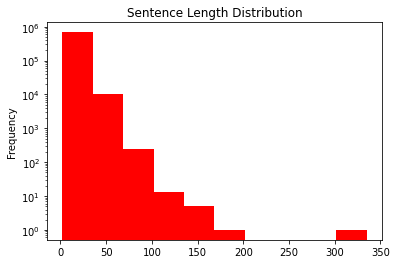

In [ ]:
# returns min, avrg and max sentence length - and also displays plot(histogram) for length distribution 
def configure_sentence_statistic(sentences):
    def sentence_len(s):
        return len(s.split())
    
    sentences.apply(sentence_len).plot(title='Sentence Length Distribution',y='Length Frequency',kind='hist', colormap='autumn', logy=True);
    return np.min(sentences.apply(sentence_len)), np.round(np.mean(sentences.apply(sentence_len))), np.max(sentences.apply(sentence_len))

min, avrg, max = configure_sentence_statistic(txt_df['sentences'])

print('minimum sentence length {} - average sentence length {} - maximum sentence length {}'.format(min, avrg, max))

In [ ]:
def DEBUG_DICTIONARY(dct, limit=10):
    print('Total Keys', len(dct))
    for i, key in enumerate(dct.keys()):
        if i > limit: break
        print(key, dct[key])

In [ ]:
# filters data according to given parameters
def filter_and_display_data(sentences, min_len=0, max_len=max, limit=3):
    result = []
    for i, sentence in enumerate(sentences):
        sent_len = len(sentence.split(' '))
        if min_len <= sent_len and sent_len <= max_len:
            result.append(sentence)
            if len(result) >= limit: break
    
    if(len(result) == 0):
        print('no such sentences found.')
        return
    
    print('{} sentences with length between {}-{}:\n'.format(limit, min_len, max_len))
    for i, s in enumerate(result):
        print(str(i+1)+")",s)

In [ ]:
filter_and_display_data(sentences, min_len=0, max_len=10, limit = 10)

10 sentences with length between 0-10:

1) სახელმწიფო უზრუნველყოფს ქვეყნის საგანმანათლებლო სისტემის ჰარმონიზაციას საერთაშორისო საგანმანათლებლო სივრცეში .
2) სასამართლოს სარჩელი წარედგინება საგადასახადო ადმინისტრაციაში მოპასუხის გადასახადის გადამხდელად რეგისტრაციის .
3) რამდენად მიზანშეწონილია პრეზიდენტი დაიტვირთოს ადმინისტრაციულ საჩივარზე ადმინისტრაციული წარმოების ჩატარებით .
4) უზრუნველყონ სახელმწიფო სტრუქტურებისა და დაწესებულებების წინამდებარე კონვენციასთან შესაბამისობაში მოქმდება .
5) უზრუნველყოფენ შეზღუდული შესაძლებლობის მქონე პირთათვის სახელმწიფო საცხოვრებელის პროგრამების მისაწვდომობას .
6) რაიონული სასამართლოების თავმჯდომარეები მათ სასამართლოებში მონიტორინგის ჩატარებაზე თანხმობას ერიდებოდნენ .
7) საბიბლიოთეკო ინტეგრირებული ავტომატიზებული სისტემის დანერგვა ეროვნული ბიბლიოთეკის სტრუქტურულ ერთეულებში .
8) პრობაცია სპაციალური სოციალური სამსახურის ზედამხედველების განსაკუთრებული მეთვალყურეობით ხორციელდებოდა .
9) გარდაცვლილი ბრალდებულის ან მსჯავრდებულის მემკვიდრეები თავისუფლდებიან საპრო

In [ ]:
filter_and_display_data(sentences, min_len=10, max_len=20, limit = 10)

10 sentences with length between 10-20:

1) მოხელის სამსახურებრივი ურთიერთობის შეჩერება ნიშნავს მოხელის დროებით განთავისუფლებას სამსახურებრივი მოვალეობის შესრულებისაგან და შესაბამისი დაწესებულების განთავისუფლებას მოხელის სამსახურით უზრუნველყოფის მოვალეობისაგან .
2) საკონსტიტუციო სასამართლოში კონსტიტუციური სარჩელის ან წარდგინების შეტანის შემთხვევაში დაუშვებელია საერთაშორისო ხელშეკრულების თუ შეთანხმების რატიფიცირება საკონსტიტუციო სასამართლოს გადაწყვეტილების გამოტანამდე .
3) საქართველოს სამინისტროს და სახელმწიფო საქვეუწყებო დაწესებულების მოხელეთა და დამხმარე მოსამსახურეთა თანამდებობრივ სარგოებს და თანამდებობათა დასახელებებს განსაზღვრავს შესაბამისი სამინისტროს ხელმძღვანელი .
4) განისაზღვრება შესაბამისი დეპარტამენტის დებულებითა და ამ დეპარტამენტის საჯარო მოსამსახურეთა თანამდებობრივი ინსტრუქციებით , რომლებსაც ამტკიცებს გენერალური დირექტორი დეპარტამენტის დირექტორის წარდგინებით .
5) გადასახადის გადამხდელისა და ხელისუფლების პასუხისმგებლობა გადასახადის გადამხდელსა და ხელისუფლებას ამ კოდექსით დად

In [ ]:
filter_and_display_data(sentences, min_len=20, max_len=30, limit = 10)

10 sentences with length between 20-30:

1) საგადასახადო ადმინისტრაციის მიერ საგადასახადო ვალდებულების აღიარების თაობაზე ბრძანების მიღებისთანავე გადასახადის გადამხდელი უფლებამოსილია , წერილობით მიმართოს საგადასახადო ადმინისტრაციას და მოითხოვოს ფულადი ვალდებულების შესრულება ამ კოდექსის 29-ე მუხლით დადგენილი ნებისმიერი ფორმით .
2) სისხლის სამართლის საქმეთა გამოძიებას აწარმოებენ საქართველოს პროკურატურის , საქართველოს შინაგან საქმეთა სამინისტროს , საქართველოს თავდაცვის სამინისტროს , საქართველოს იუსტიციის სამინისტროსა და საქართველოს ფინანსთა სამინისტროს ფინანსური პოლიციის საგამოძიებო დანაყოფების გამომძიებლები .
3) საქართველოს პარლამენტის აპარატის მოხელის და დამხმარე მოსამსახურის , აგრეთვე საქართველოს ეროვნული ბიბლიოთეკის და აუდიტორული საქმიანობის საბჭოს მოხელეთა და დამხმარე მოსამსახურეთა თანამდებობრივ სარგოებს და თანამდებობათა დასახელებებს განსაზღვრავს საქართველოს პარლამენტის თავმჯდომარე .
4) დევნის დისკრეციულობა სისხლის სამართლებრივი დევნის დაწყების გადაწყვეტილების მიღებისას პროკურორი სარგ

In [ ]:
filter_and_display_data(sentences, min_len=30, limit = 10)

10 sentences with length between 30-335:

1) 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 2

In [ ]:
MIN_SEQ_LEN = 2
MAX_SEQ_LEN = 10
msl_sentences = []

# split long sentences for fixed size
for sentence in sentences:
    words = sentence.split(' ')
    while len(words) > MAX_SEQ_LEN:
      msl_sentences.append(' '.join(words[:MAX_SEQ_LEN]))
      words = words[MAX_SEQ_LEN:]
    
    if len(words) >= MIN_SEQ_LEN:
      msl_sentences.append(' '.join(words))

msl_sentences = sorted(list(set(msl_sentences)), key=len, reverse=True)

# for sentence in msl_sentences:
#     words = sentence.split(' ')
#     X_sentences.append(' '.join(words[:len(words)-1]))
#     Y_sentences.append(words[words[:len(words)-1]])

total_df = pd.DataFrame({'sentences' : msl_sentences})
total_df.to_csv("/content/gdrive/My Drive/NL3.14/resources/geosentences.csv", index=False)
print(f'MSL Sentences Result:', len(msl_sentences), total_df.shape)

MSL Sentences Result: 1011893 (1011893, 1)


minimum sentence length 2 - average sentence length 7.0 - maximum sentence length 10


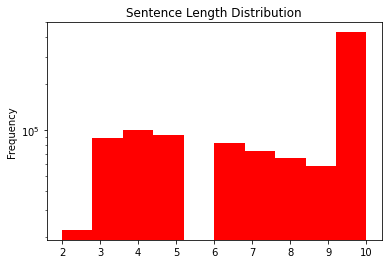

In [ ]:
min, avrg, max = configure_sentence_statistic(total_df['sentences'])

print('minimum sentence length {} - average sentence length {} - maximum sentence length {}'.format(min, avrg, max))

**Train Embddings and save them in drive**

In [ ]:
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile

fname = get_tmpfile("/content/gdrive/My Drive/NL3.14/resources/word2vec.model")

train_data = total_df['sentences'].apply(lambda x: x.split(' ')).tolist()

w2v = Word2Vec.load(fname)
# w2v = Word2Vec(sentences=train_data, sg=1, hs=1, size=300, workers=4, window=3, seed=SEED, sorted_vocab=1, min_count=3)
# w2v.train(train_data, total_examples=len(train_data), epochs=10)
# w2v.save(fname)

In [ ]:
# fix target distibution and create csv for DataLoader
def configure_data(X, Y, limit=6000):
    data = {}
    for x, y in zip(X,Y):
        if y not in data:
            data[y] = []
        if len(x) > 1:
          data[y].append(x)

    nX, nY = [], []
    for y in data:
        nX.extend(data[y][:limit])
        nY.extend([y] * len(data[y][:limit]))
    return pd.DataFrame({'x' : nX, 'y' : nY}).sample(frac=1).reset_index(drop=True)

In [ ]:
X_sentences, Y_sentences, = [] , []

# chose random split for better target exmaples
for sentence in msl_sentences:
  words = sentence.split(' ')
  for i in random.choices(range(1, len(words)), k=len(words) // 5 + 1):
      if words[-i] in w2v.wv.vocab:
        X_sentences.append(words[:-i])
        Y_sentences.append(words[-i])

final_df = configure_data(X_sentences, Y_sentences)
final_df.to_csv("/content/gdrive/My Drive/NL3.14/resources/train.csv", index=False)
print(f'Real train data filtered da ase shemdeg ^-^', final_df.shape)

Real train data filtered da ase shemdeg ^-^ (1225844, 2)


**Visualize And Analyze Word2Vec**

In [ ]:
DEBUG_DICTIONARY(w2v.wv.vocab, limit = 1)

Total Keys 145271
სხვა Vocab(code:array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1], dtype=uint8), count:9488, index:48, point:array([145269, 145268, 145266, 145262, 145255, 145241, 145215, 145165,
       145070, 144886], dtype=uint32), sample_int:4294967296)
არასამთავრობო Vocab(code:array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1], dtype=uint8), count:50, index:12847, point:array([145269, 145268, 145265, 145259, 145249, 145230, 145192, 145118,
       144980, 144726, 144260, 143402, 141840, 139134, 134470, 126759,
       114688], dtype=uint32), sample_int:4294967296)


In [ ]:
final_df['y'].value_counts()

:               6000
კი              6000
მაგრამ          6000
ამ              6000
ეს              6000
                ... 
დაეძვრინა          1
გა-დის             1
დისტრიბუტორი       1
ნასაუზმევს         1
ვიხდით             1
Name: y, Length: 113019, dtype: int64

In [ ]:
w2v.wv.most_similar('კაცი')

[('ქალი', 0.7303136587142944),
 ('ადამიანი', 0.721540629863739),
 ('ბიჭი', 0.6692333221435547),
 ('დედაკაცი', 0.6405743360519409),
 ('გოგო', 0.6321693658828735),
 ('მამაკაცი', 0.6203668117523193),
 ('კაცია', 0.5876795053482056),
 ('ყმაწვილი', 0.5731970071792603),
 ('ხალხი', 0.5724124908447266),
 ('ვინმე', 0.5575871467590332)]

In [ ]:
clusters = {'ბუნება':['კლდე', 'მთა', 'მდინარე', 'ჩანჩქერი', 'ხე', 'ბალახი', 'ციცაბო', 'ქვა', 'მუხა', 'ცაცხვი'],
            'სკოლა':['წიგნი', 'რვეული', 'ფანქარი', 'კალამი', 'მერხი', 'დაფა', 'ზარი', 'სკოლა'],
            'ადამიანი':['ადამიანი', 'მეფე', 'კაცი', 'ქალი', 'დედოფალი', 'მსახური', 'მრჩეველი', 'სასახლე'],
            'ცხოველები':['კუ', 'კურდღელი', 'მელა', 'ლომი', 'სპილო', 'კატა', 'ძაღლი', 'თაგვი'],
            'ორაზროვანი':['მეფე', 'დედოფალი', 'ჭადრაკი', 'ლომი', 'არწივი', 'ყვავი', 'კატა', 'დიდებული'],
            }


In [ ]:
# visualize data with plot diagrams
def example_plot(name):
  example_vocab = {w : w2v.wv.vocab.get(w, None) for w in clusters[name]}
  pca = PCA(n_components=2)
  result = pca.fit_transform(w2v[example_vocab])

  # create a scatter plot of the projection
  plt.scatter(result[:, 0], result[:, 1], c=np.random.rand(3,))
  plt.xlabel(name, size=16)
  words = list(example_vocab)
  for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
  plt.savefig('/content/gdrive/My Drive/NL3.14/resources/' + name + '.png', dpi=150)
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


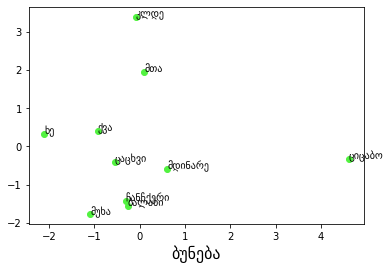

In [ ]:
example_plot('ბუნება')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


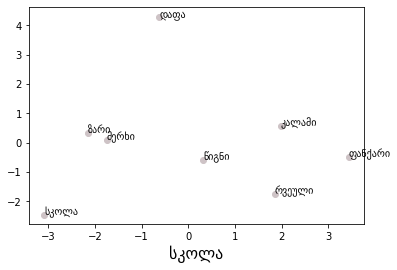

In [ ]:
example_plot('სკოლა')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


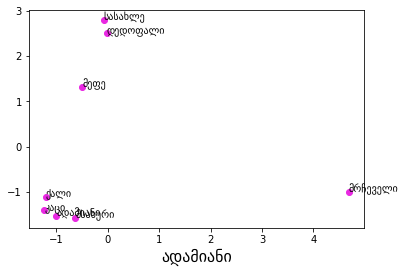

In [ ]:
example_plot('ადამიანი')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


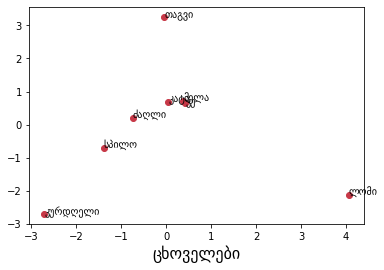

In [ ]:
example_plot('ცხოველები')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


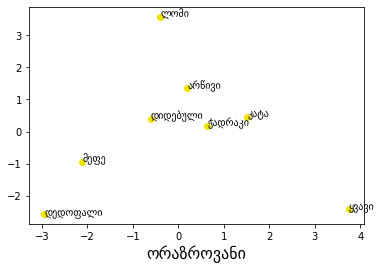

In [ ]:
example_plot('ორაზროვანი')

This is a good exmaple why we need to train our Model with Embedding layer.

In [ ]:
w2v.wv.most_similar('ლამაზი')

[('მშვენიერი', 0.7021619081497192),
 ('ჭკვიანი', 0.5880404114723206),
 ('თეთრყირმიზი', 0.5502804517745972),
 ('შნოიანი', 0.5385054349899292),
 ('საყვარელი', 0.5356854200363159),
 ('ნაზი', 0.5327546000480652),
 ('ტანწერწეტა', 0.5311012268066406),
 ('ახალგაზრდა', 0.5302516222000122),
 ('მომხიბვლელი', 0.5262815952301025),
 ('შავგვრემანი', 0.5191909670829773)]

In [ ]:
w2v.wv.most_similar('ბოროტი')

[('კეთილი', 0.4889582395553589),
 ('კეთილზე', 0.4720541834831238),
 ('გიყოფიეს', 0.4545748829841614),
 ('ხარბია', 0.4376292824745178),
 ('პატიოსანი', 0.4194127917289734),
 ('მიამიტი', 0.4016000032424927),
 ('ამპარტავანი', 0.3999917805194855),
 ('იდუმალი', 0.39943546056747437),
 ('უგუნური', 0.3985042870044708),
 ('უხორცო', 0.39846155047416687)]

In [ ]:
w2v.wv.most_similar('მოქალაქე')

[('ადამიანი', 0.45515865087509155),
 ('გელაპარაკებათ', 0.43119311332702637),
 ('სახელმწიფოს', 0.42974430322647095),
 ('სახელმწიფო', 0.4219707250595093),
 ('მათგანი', 0.4207665026187897),
 ('დემოკრატიული', 0.4026898741722107),
 ('ასრულებდეს', 0.39734411239624023),
 ('მოქალაქის', 0.3970035910606384),
 ('პროკურატურას', 0.39304280281066895),
 ('წარმომადგენელი', 0.3925755023956299)]

In [ ]:
w2v.wv.similarity('მაღალი', 'დაბალი')

0.6196934

In [ ]:
w2v.wv.similarity('მაღალი', 'საშუალო')

0.3682541

In [ ]:
w2v.wv.similarity('მაღალი', 'გრძელი')

0.44003278

In [ ]:
w2v.wv.similarity('ბოროტი', 'კეთილი')

0.48895824

In [ ]:
w2v.wv.similarity('ბოროტი', 'ეჭვიანი')

0.36356324

In [ ]:
w2v.wv.similarity('მეფე-დედოფალი', 'ცოლ-ქმარი')

0.24610178

In [ ]:
w2v.wv.similarity('მაგიდა', 'სკამი')

0.5621029

In [ ]:
w2v.wv.most_similar(positive=['პატარა', 'უზარმაზარი'], negative=['დიდი'])

[('ვეებერთელა', 0.49424439668655396),
 ('პაწია', 0.4819316864013672),
 ('კოხტა', 0.4239235520362854),
 ('პაწაწინა', 0.4238734841346741),
 ('ალაგალაგ', 0.42357882857322693),
 ('გრძელი', 0.4231351912021637),
 ('მრგვალი', 0.42095494270324707),
 ('შემოუწყო', 0.41709771752357483),
 ('კადონზე', 0.4168632924556732),
 ('სტეარინის', 0.4149708151817322)]

**დიდი : პატარა - უზარმაზარი : პაწია**

In [ ]:
w2v.wv.most_similar(positive=['მეფე', 'ქალი'], negative=['კაცი'])

[('გიორგი', 0.5323162078857422),
 ('დედოფალი', 0.4947735667228699),
 ('1072', 0.49176859855651855),
 ('დავით', 0.4878786504268646),
 ('აღსართან', 0.4824691414833069),
 ('იმერეთისა', 0.4821510910987854),
 ('რევ', 0.4820651710033417),
 ('კურაპალატისა', 0.48028799891471863),
 ('ნებროთიანი', 0.4730568528175354),
 ('მთაწმინდელი', 0.472994327545166)]

**კაცი : მეფე - ქალი : დედოფალი**


In [ ]:
w2v.wv.most_similar(positive=['სიკეთე', 'ბოროტება'], negative=['დახმარება'])

[('ბიწიერება', 0.41414934396743774),
 ('უსუსურია', 0.39170676469802856),
 ('ბოროტებაა', 0.3893987536430359),
 ('სიყვარული', 0.3820979595184326),
 ('სამართლიანობა', 0.3811679184436798),
 ('სათნოება', 0.3786270022392273),
 ('ბედნიერება', 0.3724856376647949),
 ('დამცირება', 0.37077808380126953),
 ('ცოდვა', 0.36941975355148315),
 ('გამომივლია', 0.36918729543685913)]

**დახმარება : სიკეთე - ბიწიერება : ბოროტება**

In [ ]:
w2v.wv.most_similar(positive=['დილა', 'საღამო'], negative=['დღე'])

[('მადემუაზელ', 0.37220191955566406),
 ('საზოგადოებავ', 0.35306140780448914),
 ('ღამე', 0.34357142448425293),
 ('მწუხრი', 0.333969384431839),
 ('წყნარი', 0.3280397951602936),
 ('ციხისთავს', 0.3270445466041565),
 ('მშვიდობისა', 0.3266674876213074),
 ('იცეკვებენ', 0.3265106976032257),
 ('ღრუბლიანი', 0.3206908106803894),
 ('ისაუბრებდა', 0.3198094367980957)]

**დღე : დილა - ღამე : საღამო**